In [1]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Applying Transforms to the Data
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Set dataset directory
dataset_dir = 'caltech101'

# Load Caltech101 dataset
train_data = datasets.Caltech101(root=dataset_dir, download=True, transform=image_transforms['train'])
valid_data = datasets.Caltech101(root=dataset_dir, download=True, transform=image_transforms['valid'])
test_data = datasets.Caltech101(root=dataset_dir, download=True, transform=image_transforms['test'])

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=f8e8ca97-d91b-44f4-aaa4-0eaf1953ec7e
To: /content/caltech101/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 91.6MB/s]


Extracting caltech101/caltech101/101_ObjectCategories.tar.gz to caltech101/caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /content/caltech101/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 62.3MB/s]


Extracting caltech101/caltech101/Annotations.tar to caltech101/caltech101
Files already downloaded and verified
Files already downloaded and verified


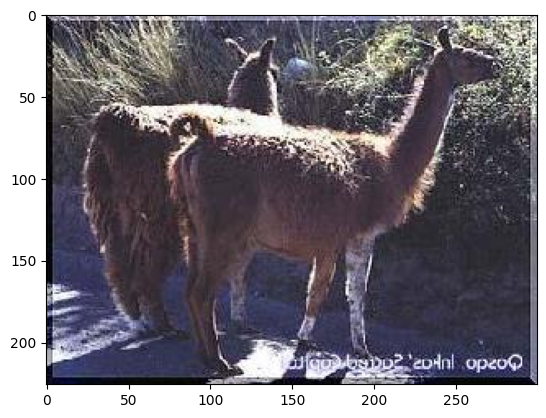

In [4]:
# Show a particular image in the dataset

# Load the image
image_path = '/content/caltech101/caltech101/101_ObjectCategories/llama/image_0004.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.show()

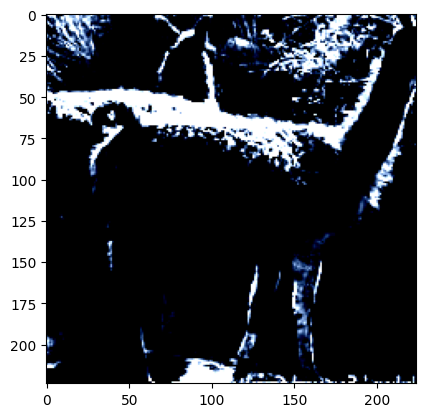

In [5]:
# Applying transforms on a particular image

# Load the image
image_path = '/content/caltech101/caltech101/101_ObjectCategories/llama/image_0004.jpg'
image = Image.open(image_path)

# Select the appropriate transformation pipeline (e.g., for validation)
selected_transform = image_transforms['valid']

# Apply the transforms to the image
transformed_image = selected_transform(image)

# Display the transformed image
plt.imshow(transformed_image.permute(1, 2, 0), cmap='gray')
plt.show()

In [6]:
# Number of classes
num_classes = len(train_data.categories)
print(num_classes)

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {i: category for i, category in enumerate(train_data.categories)}
print(idx_to_class)

101
{0: 'Faces', 1: 'Faces_easy', 2: 'Leopards', 3: 'Motorbikes', 4: 'accordion', 5: 'airplanes', 6: 'anchor', 7: 'ant', 8: 'barrel', 9: 'bass', 10: 'beaver', 11: 'binocular', 12: 'bonsai', 13: 'brain', 14: 'brontosaurus', 15: 'buddha', 16: 'butterfly', 17: 'camera', 18: 'cannon', 19: 'car_side', 20: 'ceiling_fan', 21: 'cellphone', 22: 'chair', 23: 'chandelier', 24: 'cougar_body', 25: 'cougar_face', 26: 'crab', 27: 'crayfish', 28: 'crocodile', 29: 'crocodile_head', 30: 'cup', 31: 'dalmatian', 32: 'dollar_bill', 33: 'dolphin', 34: 'dragonfly', 35: 'electric_guitar', 36: 'elephant', 37: 'emu', 38: 'euphonium', 39: 'ewer', 40: 'ferry', 41: 'flamingo', 42: 'flamingo_head', 43: 'garfield', 44: 'gerenuk', 45: 'gramophone', 46: 'grand_piano', 47: 'hawksbill', 48: 'headphone', 49: 'hedgehog', 50: 'helicopter', 51: 'ibis', 52: 'inline_skate', 53: 'joshua_tree', 54: 'kangaroo', 55: 'ketch', 56: 'lamp', 57: 'laptop', 58: 'llama', 59: 'lobster', 60: 'lotus', 61: 'mandolin', 62: 'mayfly', 63: 'meno

In [7]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(train_data)
valid_data_size = len(valid_data)
test_data_size = len(test_data)

# Create iterators for the Data loaded using DataLoader module
bs = 32
train_data_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=bs, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=bs, shuffle=True)

# Print sizes of datasets
print(f"Train data size: {train_data_size}")
print(f"Validation data size: {valid_data_size}")
print(f"Test data size: {test_data_size}")

Train data size: 8677
Validation data size: 8677
Test data size: 8677


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(train_data_size, valid_data_size, test_data_size)

8677 8677 8677


In [9]:
from torchvision.models import efficientnet_b0

In [10]:
# Load pretrained EfficientNet-B0 Model
efficientnet = efficientnet_b0(pretrained=True)
efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 59.0MB/s]


In [11]:
# Freeze model parameters
for param in efficientnet.parameters():
    param.requires_grad = False

In [12]:
# Change the final layer of EfficientNet-B0 Model for Transfer Learning
fc_inputs = efficientnet.classifier[1].in_features

efficientnet.classifier = nn.Sequential(
    nn.Linear(fc_inputs, 101),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(101, num_classes),
    nn.LogSoftmax(dim=1)  # For using NLLLoss()
)



# Convert model to be used on GPU
efficientnet = efficientnet.to(device)


In [13]:
loss_func = nn.NLLLoss()

# Define Optimizer and Loss Function with weight decay for regularization
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-5)

In [14]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25, dataset='my_dataset'): # Added dataset parameter with a default value
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
        :param dataset: Name or descriptor of the dataset (default='my_dataset')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        # Initialize lists to store true and predicted labels
        train_true_labels = []
        train_pred_labels = []

        valid_true_labels = []
        valid_pred_labels = []

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            # Store true and predicted labels
            train_true_labels.extend(labels.cpu().numpy())
            train_pred_labels.extend(predictions.cpu().numpy())

        # Calculate training metrics
        train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
        train_precision = precision_score(train_true_labels, train_pred_labels, average='macro')
        train_recall = recall_score(train_true_labels, train_pred_labels, average='macro')
        train_f1 = f1_score(train_true_labels, train_pred_labels, average='macro')

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                # Store true and predicted labels
                valid_true_labels.extend(labels.cpu().numpy())
                valid_pred_labels.extend(predictions.cpu().numpy())

        # Calculate validation metrics
        valid_accuracy = accuracy_score(valid_true_labels, valid_pred_labels)
        valid_precision = precision_score(valid_true_labels, valid_pred_labels, average='macro')
        valid_recall = recall_score(valid_true_labels, valid_pred_labels, average='macro')
        valid_f1 = f1_score(valid_true_labels, valid_pred_labels, average='macro')

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            torch.save(model, dataset+'_model_best.pt')

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc,
                        train_precision, train_recall, train_f1,
                        valid_precision, valid_recall, valid_f1])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, Precision - {:.4f}, Recall - {:.4f}, F1 Score - {:.4f} \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Precision - {:.4f}, Recall - {:.4f}, F1 Score - {:.4f}, Time: {:.4f}s".format(
            epoch, avg_train_loss, train_accuracy*100, train_precision, train_recall, train_f1,
            avg_valid_loss, valid_accuracy*100, valid_precision, valid_recall, valid_f1, epoch_end-epoch_start))

    return model, history, best_epoch


In [15]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history, best_epoch = train_and_validate(efficientnet, loss_func, optimizer, num_epochs)

torch.save(history, dataset_dir+'_history.pt')

Epoch: 1/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch : 000, Training: Loss - 2.6461, Accuracy - 44.7390%, Precision - 0.4006, Recall - 0.2267, F1 Score - 0.2460 
		Validation : Loss - 1.4689, Accuracy - 73.5969%, Precision - 0.7351, Recall - 0.5929, F1 Score - 0.6009, Time: 106.8615s
Epoch: 2/30
Epoch : 001, Training: Loss - 1.3528, Accuracy - 68.0535%, Precision - 0.5655, Recall - 0.5218, F1 Score - 0.5242 
		Validation : Loss - 0.8397, Accuracy - 82.8973%, Precision - 0.8278, Recall - 0.7411, F1 Score - 0.7483, Time: 102.7027s
Epoch: 3/30
Epoch : 002, Training: Loss - 1.0596, Accuracy - 73.6891%, Precision - 0.6401, Recall - 0.6145, F1 Score - 0.6182 
		Validation : Loss - 0.6474, Accuracy - 85.0294%, Precision - 0.8488, Recall - 0.7919, F1 Score - 0.8033, Time: 103.8467s
Epoch: 4/30
Epoch : 003, Training: Loss - 0.8994, Accuracy - 77.1811%, Precision - 0.6829, Recall - 0.6650, F1 Score - 0.6692 
		Validation : Loss - 0.5358, Accuracy - 87.6340%, Precision - 0.8713, Recall - 0.8169, F1 Score - 0.8288, Time: 103.2276s
Epoch: 5/30


In [16]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = calculate_metrics(trained_model, test_data_loader, device)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.9428
Test Precision: 0.9458
Test Recall: 0.9428
Test F1 Score: 0.9423


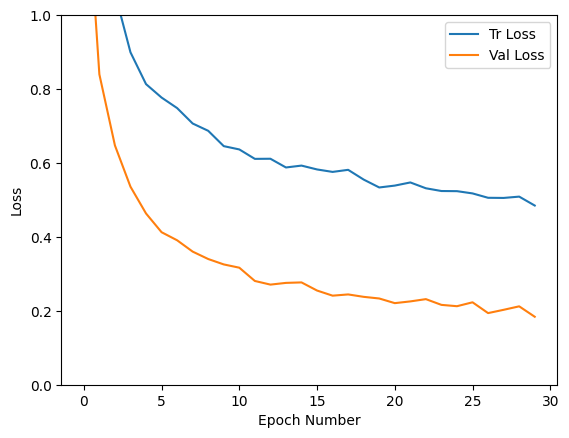

In [17]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset_dir+'_loss_curve.png')
plt.show()


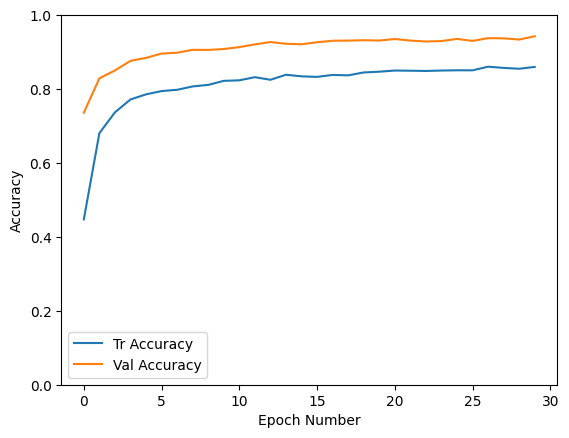

In [18]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset_dir+'_accuracy_curve.png')
plt.show()

In [19]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [20]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''

    transform = image_transforms['test']


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)

    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])




--2024-07-17 23:17:36--  https://www.ouinolanguages.com/assets/French/vocab/20/images/pic10.jpg
Resolving www.ouinolanguages.com (www.ouinolanguages.com)... 199.223.115.242
Connecting to www.ouinolanguages.com (www.ouinolanguages.com)|199.223.115.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136960 (134K) [image/jpeg]
Saving to: ‘llama.jpg’

llama.jpg           100%[===================>] 133.75K   733KB/s    in 0.2s    

2024-07-17 23:17:36 (733 KB/s) - ‘llama.jpg’ saved [136960/136960]

Predcition 1 : llama , Score:  0.99730057
Predcition 2 : emu , Score:  0.0026571744
Predcition 3 : okapi , Score:  1.4327868e-05


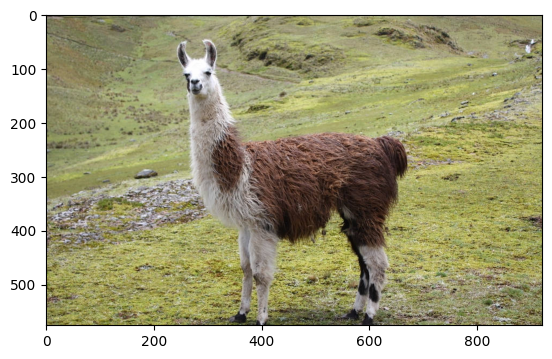

In [22]:
# Test a particular model on a test image
! wget https://www.ouinolanguages.com/assets/French/vocab/20/images/pic10.jpg -O llama.jpg
model = torch.load("my_dataset_model_best.pt")
predict(model, 'llama.jpg')

# Load Data from folders
# computeTestSetAccuracy(model, loss_func)